In [22]:
from typing import List, Optional, Callable, Iterable
from itertools import islice
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from gluonts.dataset.repository import get_dataset
from gluonts.torch.distributions import StudentTOutput
import lightning.pytorch as pl
from models.FeedForwardFromGluonTS import LightningFeedForwardNetwork

In [ ]:
from models.

Importing the dataset we want to use.

In [11]:
dataset = get_dataset("electricity")

In [13]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

Defining the Network we are going to use.

In [9]:
net = LightningFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    distr_output=StudentTOutput(),
)

In [15]:
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddObservedValuesIndicator,
    InstanceSplitter,
    ExpectedNumInstanceSampler,
    TestSplitSampler,
)

In [16]:
mask_unobserved = AddObservedValuesIndicator(
    target_field=FieldName.TARGET,
    output_field=FieldName.OBSERVED_VALUES,
)

In [17]:
training_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=ExpectedNumInstanceSampler(
        num_instances=1,
        min_future=prediction_length,
    ),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

In [18]:
from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify

In [19]:
batch_size = 32
num_batches_per_epoch = 50

In [20]:
data_loader = TrainDataLoader(
    # We cache the dataset, to make training faster
    Cached(dataset.train),
    batch_size=batch_size,
    stack_fn=batchify,
    transform=mask_unobserved + training_splitter,
    num_batches_per_epoch=num_batches_per_epoch,
)

In [23]:
trainer = pl.Trainer(max_epochs=10)
trainer.fit(net, data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/adriencortes/Documents/13- Articles/7- TimeGrad/timegrad/lightning_logs

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | nn        | Sequential | 144 K  | train
1 | args_proj | PtArgProj  | 147    | train
-------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)
/Users/adriencortes/Documents/13- Articles/7- TimeGrad/pytorch-ts-master/pytorchts/lib/python3.9/site-packages/gluonts/dataset/common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [24]:
prediction_splitter = InstanceSplitter(
    target_field=FieldName.TARGET,
    is_pad_field=FieldName.IS_PAD,
    start_field=FieldName.START,
    forecast_start_field=FieldName.FORECAST_START,
    instance_sampler=TestSplitSampler(),
    past_length=context_length,
    future_length=prediction_length,
    time_series_fields=[FieldName.OBSERVED_VALUES],
)

predictor_pytorch = net.get_predictor(mask_unobserved + prediction_splitter)

In [25]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator

In [26]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, predictor=predictor_pytorch
)

forecasts_pytorch = list(f.to_sample_forecast() for f in forecast_it)
tss_pytorch = list(ts_it)

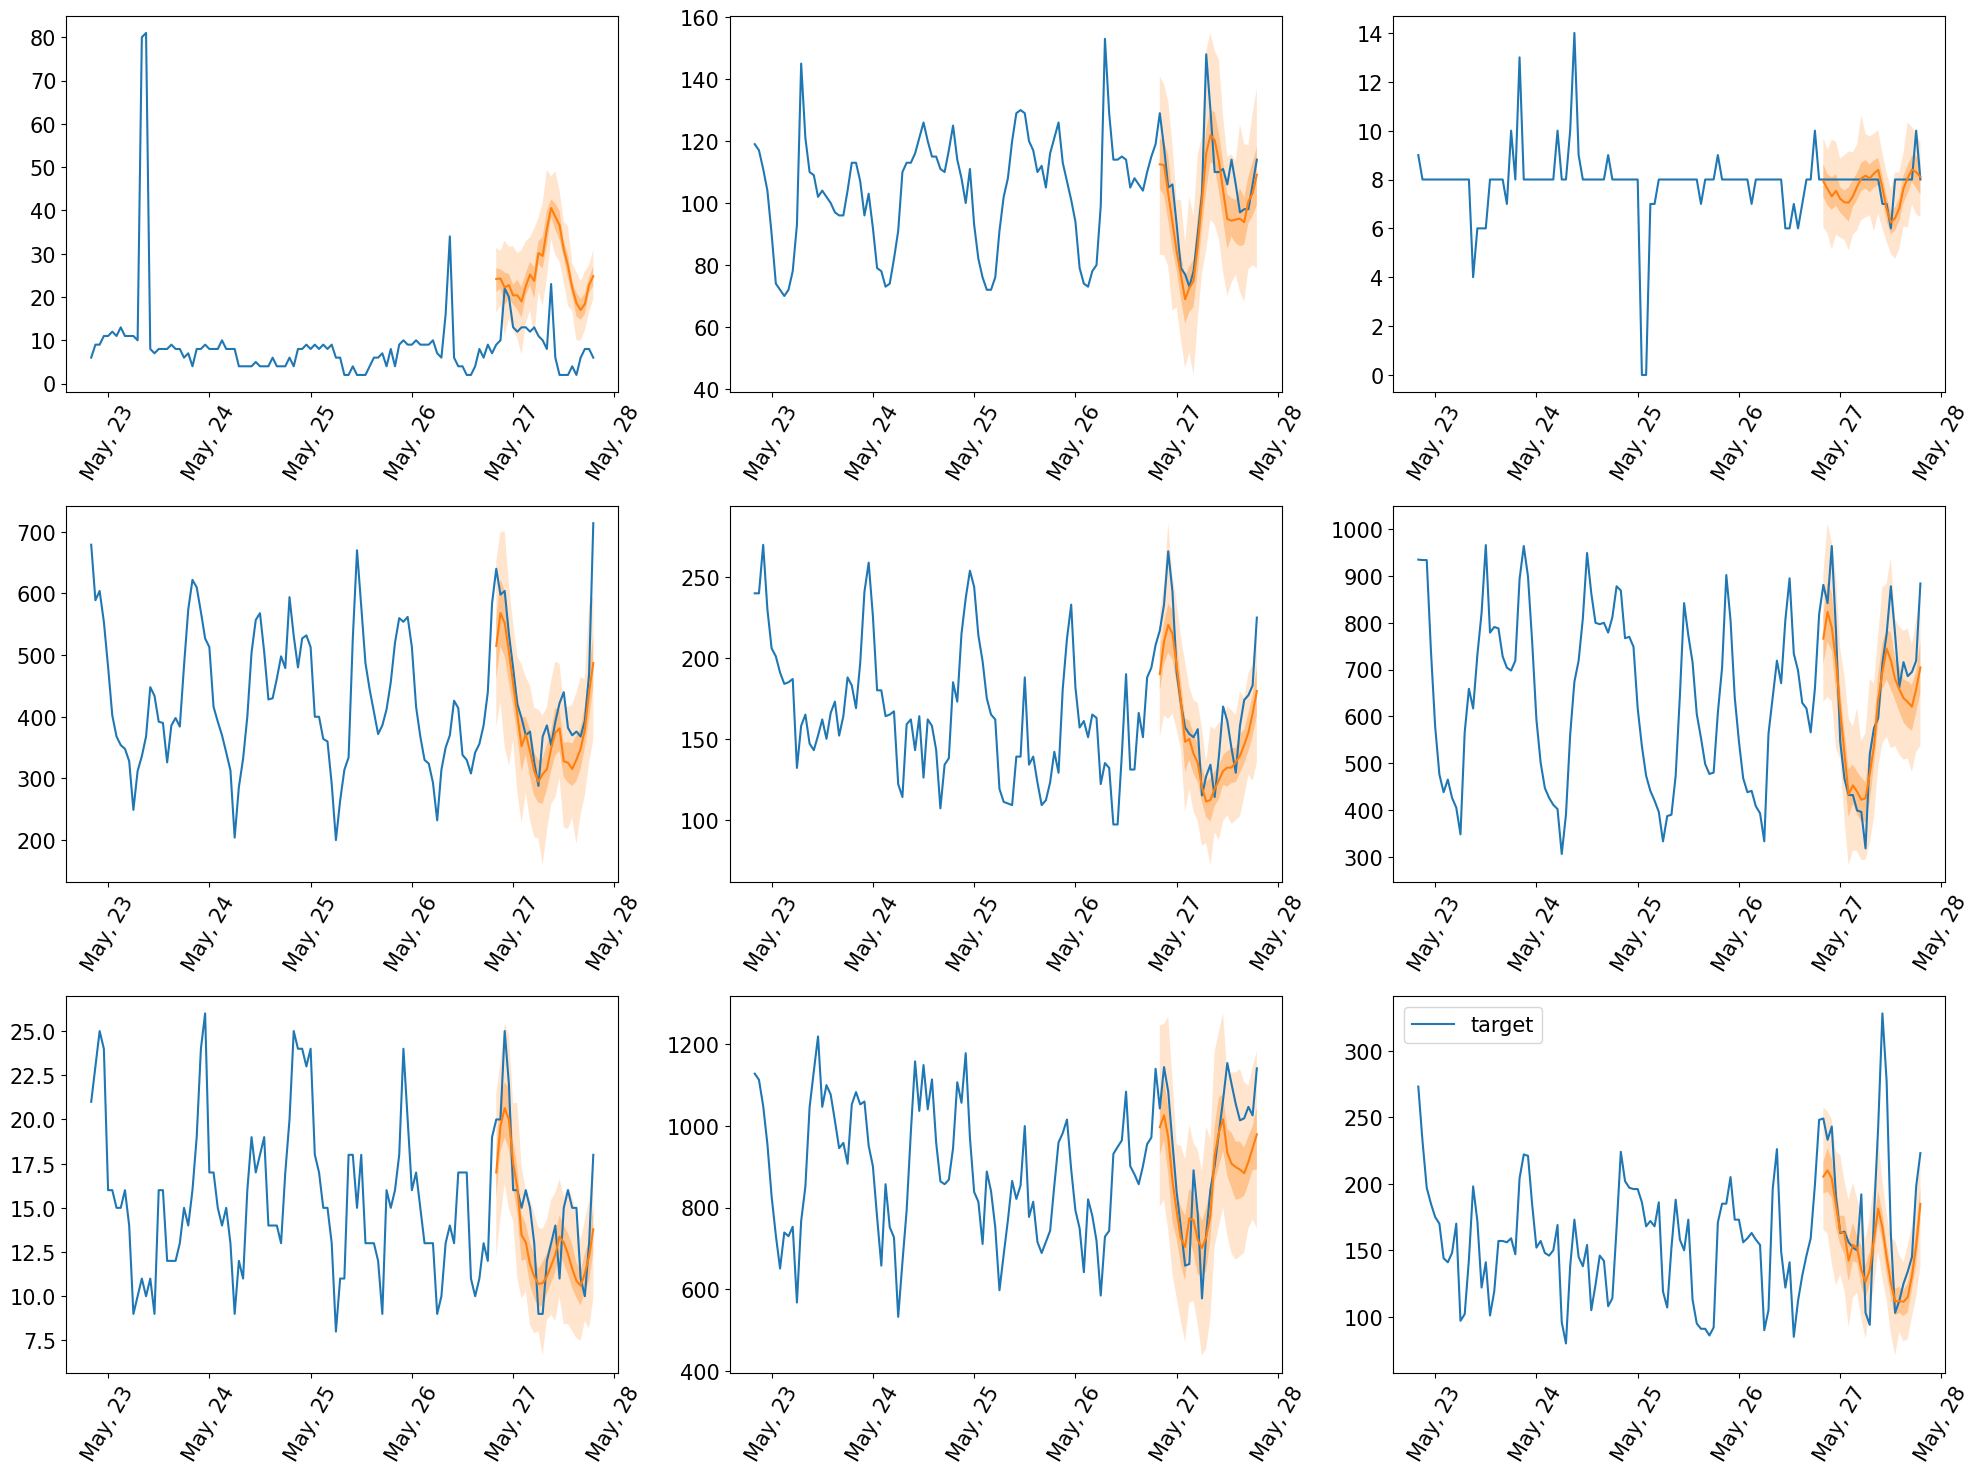

In [27]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.plot(ts[-5 * prediction_length :].to_timestamp(), label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()